# [LELEC2870] - Machine Learning

## Practical session 7 - (Nonlinear) Dimensionality Reduction

Prof. M. Verleysen<br>
Prof. J. Lee<br>

**Teaching assistants :**  
Edouard Couplet : edouard.couplet@uclouvain.be  
Seyed Ghasemzadeh : seyed.ghasemzadeh@uclouvain.be  
Niels Sayez : niels.sayez@uclouvain.be  
Mathieu Simon : mathieu.simon@uclouvain.be  
Antoine Vanderschueren : antoine.vanderschueren@uclouvain.be

## Introduction

Dimensionality reduction (DR) is an important tool to analyze high dimensional data. It can be used for visualization, compression and as a preprocessing step for other algorithms [1]. In this exercice session, we will focus mainly on the visualization aspect. 

Data visualization is usually performed to gain some insights about the structure of the data: how is the data distributed in space ? Are there several groups of points (clusters) ? Is the data distributed along a particular manifold (subspace embedded in another space, usually of higher dimension) ? Answering these question is rather simple when we have 2D or 3D data. However, this can quickly lead to serious headaches when considering higher dimensional data and this is exactly where DR comes in. **The goal of DR is thus to provide a faithful low dimensional representation (usually 2D) of high dimensional data**. 

Almost always, DR involves a loss of information. We must therefore ask ourselves what a "faithful" representation means. For what criterion do we want to optimize? In this course, you have seen two big families of methods that optimize different (although related) criteria: 
- methods based on distance preservation 
- methods based on topology preservation

Let's now put this into practice !

<div class="alert alert-info">
<b>Disclaimer</b>  <br>
The purpose of this session is to give you the intuition of how the DR methods work. The mathematical developments presented are not always rigorous and the algorithms are not necessarily implemented in the best way. For more rigorous stuff, see the appropriate references.
</div>

<div class="alert alert-info">
<b>Remark on notations</b>  <br>
Througout the course and the litterature, many different notations are used to refer to the observed variables and to the embedded/latent variables. In this exercise session, we will systematically use $X$ to denote the observed high dimensional data, and $Y$ to denote the low dimensional data obtained trough DR algorithm with $X$ as input.
</div>

### Usual imports

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE

## 1) Distance preservation

Theses methods reduce the dimensionality of data by using distance preservation as the optimization criterion.

### Toy dataset
Let's create a toy dataset to explore a few methods seen in the course. The "high-dimensional" 3D data will be uniformly distributed on a 2D manifold : a sphere. The goal will be to find a faithful 2D representation of the data.



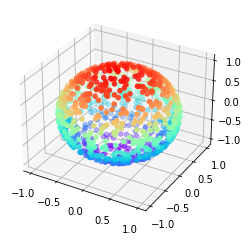

In [2]:
# Generation of n samples from uniform distribution on the surface 
# of a unit sphere centered at the origin 
np.random.seed(7)
n_samples = 1000

# use parametric representation of a sphere
theta = np.arccos(2*np.random.rand(n_samples)-1)
phi = np.random.rand(n_samples) * 2 * np.pi 
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# data matrix
X = np.array([x, y, z])

# 3d plot  
# note: matplotlib does not support equal axis in 3d so the sphere may look more like an ellipsoid

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(x, y, z, c = z, cmap=plt.cm.rainbow)
plt.show()

# Manifold because if we zoom, it will look like a plane (like Earth) but here it's just a surface, non filled. If 
#  zoom, it's 1D (for a 1D manifold). Locally but must be true everywhere.

### The classics of the classics : PCA and classical MDS

We cannot talk about principal component analysis (PCA) and classical multidimensional scaling (MDS) without mentioning the singular value decomposition (SVD). You have probably seen it it many courses by now but a quick recap cannot hurt annyone ;)

#### SVD 

For the data matrix $X$, we will stick to the convention mostly used in the course : $X$ is a $m$ by $n$ matrix with $m$ features and $n$ samples (a column corresponds to a sample and a row to a feature).

The singular value decomposition of $X$ is given by: $X = VSU^{T}$. Recall that $S$ is diagonal and contains the singular values while $V$ and $U$ are orthonormal and contain the left and right singular vectors.

The singular vectors $V$ can be found by eigen value decomposition (EVD) of the covariance matrix :

\begin{equation}
\hat{\Sigma}_x = XX^T = VSU^TUSV^T = VS^2V^T = V\Lambda V^T \hspace{1cm} (S=\Lambda^{\frac{1}{2}})
\end{equation}

Similarly, the singular vectors $U$ can be found by EVD of the Gram matrix :

\begin{equation}
\hat{\Gamma}_x = X^TX = USV^TVSU^T = US^2U^T = U\Lambda U^T \hspace{1cm} 
\end{equation}

Finally, we can truncate the SVD in order to obtain the best rank P matrix approximation of $X$ (with P< min($m$,$n$)):

\begin{equation}
\tilde{X} = V_PS_{P,P}U_P^T = argmin_{\tilde{X}}||X-\tilde{X}||_F^2
\end{equation}

#### PCA 

Again this is nothing new ;) Recall that the goal of PCA is to find a projection $Y=WX$ such that the covariance matrix $\hat{\Sigma}_y$ is diagonal (identity matrix if whitening).

We have 

\begin{equation}
\hat{\Sigma}_y = YY^T = WXX^TW^T = W\hat{\Sigma}_xW^T
\end{equation}

Now we perform EVD of $\hat{\Sigma}_x$ and obtain 

\begin{equation}
\hat{\Sigma}_y =  WV\Lambda V^TW^T 
\end{equation}

Since $V^TV=I$, we see that $V^T$ is a solution and gives $\hat{\Sigma}_y = \Lambda$

In the context of dimensionality reduction, if we want to reduce $m$-dimensional data $X$ to $p$-dimensional data while best preserving the variance, we can use :

\begin{equation}
Y =  V_p^TX
\end{equation}

We will see in a moment how we can also interpret PCA as best preserving the pairwise distances between data points.

<div class="alert alert-success">
<b> Very simple implementation of PCA </b>  <br>
Complete the given function and perform PCA on the toy dataset in order to obtain a 2D representation of the sphere
</div>

In [6]:
def simplePCA(X):
    v,s,uh = np.linalg.svd(np.copy(X))
    Y = np.matmul(v.T, X)
    # Y = v[:,:2].T@X
    return Y

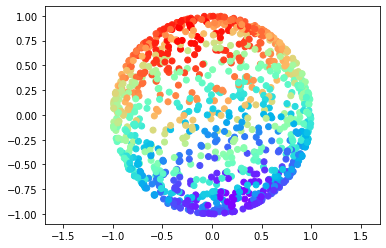

In [7]:
Y = simplePCA(X)

fig = plt.figure()
plt.axis('equal')
plt.scatter(Y[0,:], Y[1,:], c = z, cmap=plt.cm.rainbow)
plt.show()

# Expected ?
# There are intrusions, red points close to yellows one, and they should not be (close in 2D but far apart in 3D)
# Extrusion : close in 3D far apart in 2D
# here we have intrusions.

<div class="alert alert-warning">
<b> Question </b>  <br>
Observe the projection. Can you see extrusions ? Can you see intrusions ? Is it what you expected ?
</div>

#### Classical MDS

The idea behind classical MDS is also to find a projection of the data : $Y=WX$ with $W$ orthogonal. In this case however, it is assumed that $X$ is unknown, instead we only have the Gram matrix $\hat{\Gamma}_x = X^TX$ at our disposal.

We have that $\hat{\Gamma}_x = X^TX = Y^TY \hspace{1cm}$ ( trivial with orthogonality of $W$: $Y^TY = X^TW^TWX = X^TX$ )

And thus we don't need to find $W$ explicitly ; with the EVD of  $\hat{\Gamma}_x$, we can directly make $Y^TY$ appear :

\begin{equation}
 \hat{\Gamma}_x = U\Lambda U^T = U\Lambda^{\frac{1}{2}}\Lambda^{\frac{1}{2}}U^T = (\Lambda^{\frac{1}{2}}U^T)^T(\Lambda^{\frac{1}{2}}U^T) = Y^TY
\end{equation}
and thus we find $Y=\Lambda^{\frac{1}{2}}U^T$

For dimensionality reduction, we can take $Y=\Lambda^{\frac{1}{2}}_{P,P}U_P^T$

<div class="alert alert-success">
<b> Very simple implementation of classical MDS </b>  <br>
Complete the given function and perform MDS on the toy dataset in order to obtain a 2D representation of the sphere
</div>

In [12]:
def simpleMDS(G):
    u,lmbd,uh = np.linalg.svd(np.copy(G)) # SVD for positive semi definite matrix is same as EVD
    #Y = TO DO -> Pay attention to the shape of lmbd... np.diag() may be useful
    Y = np.diag(lmbd[:2]**0.5)@u[:,:2].T  # Take first two column then transpose (for u)
    return Y

# Y = lambda^1/2  *  U.T
# Decompose fct of G to U * lambda * U.T
#       G has (1000x1000)  // U & lambda have (1000x1000) too
#             On veut un Y = (2x1000)
# np.diag to transform vector to a matrix diagonal

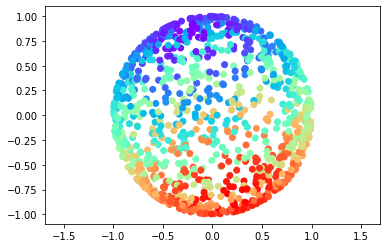

In [13]:
G = X.T@X #obviously, in this case we know X, but let's assume we only have G ;)

Y = simpleMDS(G)

fig = plt.figure()
plt.axis('equal')
plt.scatter(Y[0,:], Y[1,:], c = z, cmap=plt.cm.rainbow)
plt.show()

# They're exactly the same because
# Result of PCA : Y = V.T * X
# Result of MDS : Y = lambda**1/2 * U.T

# Okay because PCA -> X.T*X = V.T * V*S*U.T = S*U.T = lambda**1/2 * U.T
# Okay because S = lambda**1/2 like defined before.

<div class="alert alert-warning">
<b> Question </b>  <br>
Compare with the result of PCA. What do you observe ? (you may want to plot -Y[0,:] and -Y[1,:] for MDS)
</div>

<div class="alert alert-success">
<b> Little proof </b>  <br>
As you should have observed, PCA and classical MDS provide the same results (up to sign) ! Try to prove that $Y = V^TX = \Lambda^{\frac{1}{2}}U^T$ (hint : use the SVD of $X$)
</div>

One thing that we have not made very clear so far, is how PCA and classical MDS do actually preserve distances.

Well, first of all, they do not preserve the pairwise distances, but the pairwise inner scalar products. The relation between the two is :
\begin{equation}
||x_i-x_j||^2 = (x_i-x_j)^T(x_i-x_j)
\end{equation}

We can show that dimensionality reduction through Classical MDS (and thus also PCA) indeed preserves these pairwise scalar products to the maximum:


\begin{equation}
 \hat{\Gamma}_y = Y^TY = (\Lambda^{\frac{1}{2}}_{P,P}U_P^T)^T(\Lambda^{\frac{1}{2}}_{P,P}U_P^T) = U_P\Lambda_{P,P} U_P^T = \tilde{\Gamma}_x = argmin_{\tilde{\Gamma}_x}||\Gamma_x-\tilde{\Gamma}_x||_F^2
\end{equation}


<div class="alert alert-warning">
<b> Question </b>  <br>
Imagine that the data matrix X $\in R^{m\times n}$ is available and that you want to project the data in a 2 dimensional space for visualization. Also, imagine that you dont know how SVD works, only EVD. Knowing that PCA and classical MDS will give the same results, in which cases would you :
    <li> perform PCA with an EVD of the covariance matrix $XX^T$ ?  if m << n (because we work with a (3x3) matrix instead of (1000x1000) in the example of a (1000x3)
    <li> perform classical MDS with an EVD of the Gram matrix $X^TX$ ? if n << m
    <li> (PS : care here that mxn for matrix are feature x sample in our course but not on the internet.)
</div>





### Gradient descent of a stress function : Metric MDS and others

Metric MDS is a generalization of classical MDS, it preserves the pairwise distances explicitly by minimizing the following cost function, also known as "stress function" :

\begin{equation}
E_{mMDS}=\sum_{i=1,j>i}^n(\delta_{ij}-d_{ij})^2
\end{equation}

where $\delta_{ij}=\sqrt{\sum_{k=1}^p(x_k(i)-x_k(j))^2} \hspace{0.5cm}$   and  $\hspace{0.5cm}d_{ij} = \sqrt{\sum_{k=1}^p(y_k(i)-y_k(j))^2}$.

We want to do gradient descent on it to find a solution.

The points $y$ are initialized either randomly, or with some other method such as PCA (for faster convergence) then the coordinates are updated by descending the gradient of $E_{mMDS}$. There is no analytical solution.

The stress function can be modified to penalize or encourage certains apsect of the low dimensional representation such as intrusions and extrusions.

For example, in Sammon's mapping (NLM), the stress function is given by :

\begin{equation}
E_{NLM}=\sum_{i=1,j>i}^n\frac{(\delta_{ij}-d_{ij})^2}{\delta_{ij}}
\end{equation}

In Curvature component analysis (CCA), the stress function is given by :

\begin{equation}
E_{CCA}=\sum_{i=1,j>i}^n\frac{(\delta_{ij}-d_{ij})^2}{d_{ij}}
\end{equation}

We optimize given these.

<div class="alert alert-warning">
<b> Question </b>  <br>
    What do the sress functions of NLM and CCA encourage and/or penalize ?
    <li> The $\frac{1}{\delta_{ij}}$ in the stress of NLM will allow intrusions or extrusions ? It allows intrusions. if ${\delta_{ij}}$ is big, it doesn't penalize small distances in reduced space. It is the left one
    <li> The $\frac{1}{d_{ij}}$ in the stress of CCA will allow intrusions or extrusions ? It allows extrusions (some points close in sphere and far in reduced). If ${d_{ij}}$ is big it don't penalize extrusions. Allows is different from encourage, it allows here. It is the right one.
        
Based on your answers, which of the two 2D representations of the spere here bellow corresonds to NLM ? and to CCA ?
        
</div>

<img src="data\NLM_CCA.PNG" width = "600">



## 2)  Topology preservation

Some methods focus on preserving the topology rather than the pairwise distances. This means preserving the neighborhood: for each point, the K-nearest neighbors in the low dimensional representation should be the same as the K-nearest neighbors in high dimension, regardless of the pairwise distances.

### The very famous t-SNE

The large family of stochastic neighbor embedding methods is based on topology preservation; its most popular member is undoubtedly the t-distributed stochastic neighbor embedding, or t-SNE.

#### t-SNE on the toy dataset

<div class="alert alert-success">
<b> Simple application of t-SNE </b>  <br>
Use the TSNE class from $\texttt{sklearn}$ with default parameters on the toy sphere dataset (pay attention to the shape of the arguments, you may have to transpose X)
</div>

/home/thomas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


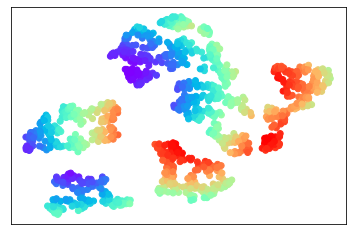

In [28]:
# Y = TO DO
Y = TSNE(perplexity=30).fit_transform(X.T) # Aucune idée des bons arguments...
# Perplexity preserve larger or lower number of points (perplexity argument). Preserve structure of points.

fig = plt.figure()
plt.scatter(Y[:,0], Y[:,1], c=z,cmap=plt.cm.rainbow)
plt.xticks([])
plt.yticks([])
plt.show()

<div class="alert alert-warning">
<b> Question </b>  <br>
Observe the results. Is this what you expected ? Would you argue that it is a better or a worse 2D representation than the one obtained with PCA or MDS ?
    
Worst representation of manifold, because lose and don't see as much as PCA (for the sphere)
</div>

#### The math behind Stochastic Neighbor Embedding (SNE)

Let's get a bit more familiar with the equations of stochastic neighbor embedding [2]:

To switch from distance preservation to neighborhood preservation, SNE starts by converting the high dimensional euclidean distances $\delta_{ij}$ to similarities $\sigma_{ij}$:

\begin{equation}
\sigma_{ij} = \frac{exp(-\frac{\delta_{ij}^2}{2\lambda_i^2})}{\sum_{k,k\neq i}exp(-\frac{\delta_{ik}^2}{2\lambda_i^2})}
\end{equation}

We see that $\delta_{ij}$ is mapped to the probability density of $x_j$ under a gaussian centered at $x_i$ and is then normalized such that $\sum_{j,j\neq i}\sigma_{ij}=1, \forall i$.
This means that, for a given $x_i$, $\sigma_{ij}$ can be interpreted as the probablity that $x_j$ would be "picked" as a neighbor, if neighbors were "picked" in proportion to their probability density under a gaussian centered at $x_i$ [3]. In simpler words, $\sigma_{ij}$ can be interpreted as the probablity that $x_j$ is in the neighborhood of $x_i$. Because $\sum_{j,j\neq i}\sigma_{ij}=1$ it also means that the vector $\mathbf{\sigma_{i}}= [\sigma_{i0},\sigma_{i1},...,\sigma_{i(n-1)}]$ can be interpreted as a probability distribution. 

Here is an illustration of the conversion from distances to similarities :

<img src="data\tsne1.PNG" width = "600">



The same conversion scheme is applied to the low dimensional euclidean distances $s_{ij}$. The vector $\mathbf{s_{i}}= [s_{i0},s_{i1},...,s_{i(n-1)}]$ contains for each point $x_{j}$ the probality of it being in the neighborhood of $y_i$.

sigma is similarity (with proba of beeing neighbor) in original space and "s" is same but in reduced space, we want sigma and "s" to be the closest possible here !

For a given $x_i$ and its corresponding low dimensional $y_i$, we would like to have $\mathbf{\sigma_{i}}=\mathbf{s_{i}}$. Indeed this would mean that the high dimensional $x_i$ has the same neighbors as the low dimensional $y_i$ (in terms of probabilities). This can be obtained (or approached) by minimizing the KL-divergence between $\mathbf{\sigma_{i}}$ and $\mathbf{s_{i}}$. The KL-divergence is a measure of the distance between the two distributions $\mathbf{\sigma_{i}}$ and $\mathbf{s_{i}}$ and is given by :

\begin{equation}
KL(\mathbf{\sigma_{i}}||\mathbf{s_{i}}) = \sum_{j} \sigma_{ij}\log\frac{\sigma_{ij}}{s_{ij}}
\end{equation}

And since we want to minimize $KL(\mathbf{\sigma_{i}}||\mathbf{s_{i}})$ for all $i$'s, the cost of SNE can be written as:

\begin{equation}
C_{SNE} = \sum_{i} \sum_{j} \sigma_{ij}\log\frac{\sigma_{ij}}{s_{ij}}
\end{equation}

We have not yet mentionned the parameter $\lambda_i$ in the equation of $\sigma_{ij}$. By varying this parameter, we can account for variations in the density of the data. Indeed, chances are that some groups of points will form more dense or sparse clusters/manifolds than others, but since it is the topology that matters and not the distances, we want to treat these groups in the same way. 

In the exemple bellow, we see that when we keep a fixed $\lambda$ for all $i$'s, we are not capable of treating the "purple cluster" in the same way as the "green cluster" despite the fact that they have the exact same topology. If we now allow differents $\lambda_i$s for for different $i$'s, we manage to handle both clusters in the same way. In particular, we need to augment $\lambda_i$ when $x_i$ is the center point of the "purple cluster". This adjusts the bandwith of the gaussian and leads to the same similarity conversion as for the "green cluster". Note that there is no need for a parameter $\lambda$  in the definition of $s_{ij}$ since there is no notion of scale in the reduced space.

<img src="data\tsne2.PNG" width = "1000">

We want to tune $\lambda_i$ such that we always consider about the same number of points in the neighborhood of $x_i$, for all $i$'s. A typical indicator of this number of neighbors is the perplexity $K$:

\begin{equation}
\log_2 K = -\sum_j \sigma_{ij}\log_2\sigma_{ij}, \forall i
\end{equation}
\begin{equation}
 K = 2^{-\sum_j \sigma_{ij}\log_2\sigma_{ij}} , \forall i
\end{equation}

Don't bother to much with the math, if you want more details, go check concepts such as entropy and cross entropy. The important thing to note is that $K$ is a increasing function of $\lambda$ : $K = f(\lambda)$. The perplexity can thus be passed as a parameter $K_*$ defined by the user and we can perform binary search during execution to find a value of $\lambda_i$ for each $i$ that satisfy $f(\lambda_i)=K_*$ . 

K is a fonction of parameter lambda (same lambda that appears in the definition of the sigma). We try values of lambda until we find one that obtain the correct perplexity. K is the Number of points in neighborhood that we want to preserve.

#### A practical example

Nothing is better than a practical example to understand how things work. We have created a small synthetic dataset to see how the density of the points and the choice of the perplexity affects the parameter $\lambda$.


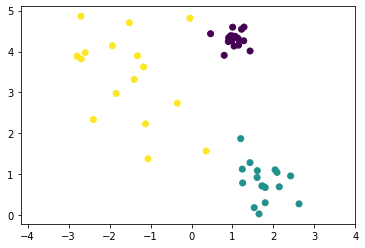

In [29]:
from sklearn.datasets import make_blobs
X_syn, labels = make_blobs(n_samples=50, centers=3, cluster_std=[0.2,0.5,1], n_features=2, random_state=0)
fig = plt.figure()
plt.axis('equal')
plt.scatter(X_syn[:,0],X_syn[:,1],c=labels)
plt.show()

<div class="alert alert-success">
<b> More intuition for perplexity </b>  <br
                                            
We have created a small tool that will hopfully enable you to better grasp the relationship between perplexity, data density and $\lambda$.

Run the cell at the end of the notebook that contains the $\texttt{intuition_plots}$ function. For a given point $i$ and a given perplexity $K$, the function will display 4 things :
    <li> a plot of the data points colored by similarity with respect to the point $x_i$ (circled in black). Purple or dark blue means no similarity, and any other color means that the points are more or less in the neighborhood of $x_i$. Red means very similar.
    <li> an histogram that shows the distribution of the similarities in the high dimensional space
    <li> a graph that shows the relationship between $K$ and $\lambda$, together with the results of the binary search
    <li> the value $\lambda_i$ corresponding to $x_i$
        
Play around with different preplexities and different point until you fill you understand how everything interacts together
</div>

In [30]:
intuition_plots(X_syn,i=0,K=25) # TO MODIFY

NameError: name 'intuition_plots' is not defined

#### Finals steps towards t-SNE

In t-SNE, the high dimensional similarities $\sigma_{ij}$ are symmetrized and $s_{ij}$ is defined based on a student's t-distribution with one degree of freedom instead of a gaussian :

\begin{equation}
s_{ij} = \frac{(1+d_{ij}^2)^-1}{\sum_{k,l,k\neq l}(1+d_{kl}^2)^-1}
\end{equation}

The student's t-distribution has a heavier tail than the gaussian and this helps to alleviate the crowing problem which SNE suffers from. Indeed, SNE has a tendency to crush all the data in the middle of the reduced space and struggles to separate different clusters and/or manifolds. With a heavier tail, the student's t-distribution puts an emphasis on bringing closer similar points and pushing more apart dissimilar points ; in a way, it provides "more space" to accommodate the data. Here is a (not very rigorous) illustration for some intuition on why this is the case :

<img src="data\tsne3.PNG" width = "600">

For more technical and rigorous details, please refer to the litterature [2].


<div class="alert alert-success">
<b> t-SNE on the toy dataset : rematch ! </b>  <br>
Now that you better understand what t-SNE is and how it works, try to modify the adequate parameter in the TSNE function from $\texttt{sklearn}$ in order to obtain a better 2D representation of the sphere. 
</div>

/home/thomas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


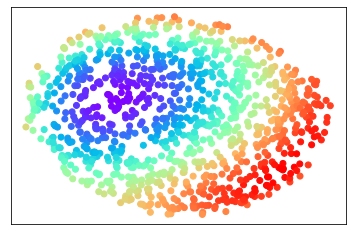

In [31]:
Y = TSNE(perplexity=500).fit_transform(X.T) # Aucune idée des bons arguments...
# Perplexity preserve larger or lower number of points (perplexity argument). Preserve structure of points.

fig = plt.figure()
plt.scatter(Y[:,0], Y[:,1], c=z,cmap=plt.cm.rainbow)
plt.xticks([])
plt.yticks([])
plt.show()

###  Finally , let's apply t-SNE to some real high dimensional datasets

#### MNIST

This MNIST dataset contains 1500 gray-scale images of scanned handwritten digits[4]. There are 150 images per digit. The images are square with height and width of 28 pixels.

<img src="data\mnist.png" width = "600">

<div class="alert alert-warning">
<b> Question </b>  <br>
Try to think of a relevant 2D representation of the MNIST data; what should it look like ?
</div>

<div class="alert alert-success">
<b> MNIST t-SNE </b>  <br>
Apply tSNE to the MNIST data. Try to find the most relevant parameters. Is it better to start with a random initialization or with something else ?
</div>

/home/thomas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/thomas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


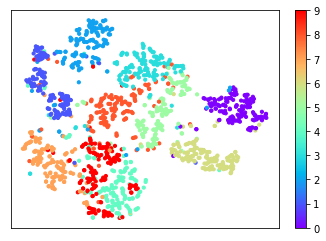

In [34]:
mnist = scipy.io.loadmat(f"data/MNIST.mat")
X=mnist['X_hds']
labels=mnist['t']

# Y =  TO DO
Y = TSNE(n_components=2, perplexity=10, init='pca').fit_transform(X)

fig = plt.figure()
plt.scatter(Y[:,0], Y[:,1],s=10, c=labels[0],cmap=plt.cm.rainbow)
plt.colorbar() 
plt.xticks([])
plt.yticks([])
plt.show()

# Cluster of 1 should be close to 7, because very close in term of pixels.
# Two part of cluster of 4 because two ways of writing it.

# We don't have to start with random points, start with pca of dataset ? (not always the case tough)

<div class="alert alert-warning">
<b> Question </b>  <br>
Does the embedding make sense ?
</div>

#### COIL_20

The COIL-20 dataset contains 72 gray-scale images of 20 different objects [5]. The 72 images correspond to rotation of 5 degree around each object. All images are square with height and width of 128 pixels.

<img src="data\coil20.PNG" width = "600">

<div class="alert alert-warning">
<b> Question </b>  <br>
Try to think of a relevant 2D representation of the COIL-20 data; what should it look like ? Try to find some manifold maybe. (manifold in a 128x128 space will be on a line in this huge space) (seen as a vector and line follow the vector representation ?)
</div>

<div class="alert alert-success">
<b> MNIST t-SNE </b>  <br>
Apply tSNE to the COIL-20 data. Try to find the most relevant parameters. Is it better to start with a random initialization or with something else ?
</div>

/home/thomas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


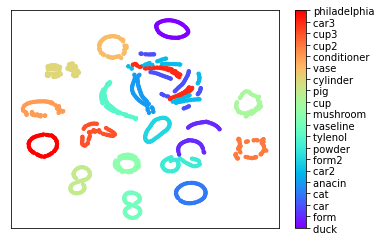

In [35]:
coil20 = scipy.io.loadmat(f"data/COIL_20.mat")
X=coil20['X_hds']
labels=coil20['t']

#Y = TO DO
Y = TSNE(n_components=2, perplexity=7).fit_transform(X)


fig = plt.figure()
plt.scatter(Y[:,0], Y[:,1],s=10, c=labels[0],cmap=plt.cm.rainbow)
plt.colorbar(ticks=range(20)).ax.set_yticklabels(coil20['obj_name']) 
plt.xticks([])
plt.yticks([])
plt.show()

# Use low perplexity because very close range for neighborhood are needed to be good. (don't create cluster of points)
# We don't use pca as initializer because pca does a linear combinaison of image so of pixels.
#   we lose structural information doing this with images.

<div class="alert alert-warning">
<b> Question </b>  <br>
Does the embedding make sense ?
</div>

## Final thoughts

<div class="alert alert-warning">
<b> Question </b>  <br>
In your opinion, what is the most significant difference between distance preserving methods and topology preserving methods ?
What are their respective advantages and disadvantages ?
</div>



### Code for Intuition_plots()

In [ ]:
def sigma_i(dx, lmbd, i):
    sigma_i=np.exp(-(dx[i,:]**2)/(2*lmbd**2))
    sigma_i[i]=0
    sigma_i=sigma_i/(np.sum(sigma_i))
    return sigma_i

def f(sigma):
    return 2**(-sigma.reshape(1,-1)@np.log2(sigma.reshape(-1,1)+1e-6))

def binary_search(dx,i,K,n,maxLambda=10,tol=0.01,max_iter=25):
    lmbd_h=maxLambda
    lmbd_l=0
    lmbd=(lmbd_h+lmbd_l)/2
    k=f(sigma_i(dx,lmbd,i))
    error=np.abs(k-K)/K
    it=0
    k_list=[k,]
    lmbd_list=[lmbd,]
    while(error>=tol or it>=max_iter):
        if(k>K):
            lmbd_h=lmbd_h-((lmbd_h-lmbd_l)/2)
        else:
            lmbd_l=lmbd_l+((lmbd_h-lmbd_l)/2)
        lmbd=(lmbd_h+lmbd_l)/2
        lmbd_list.append(lmbd)
        k=f(sigma_i(dx,lmbd,i))
        k_list.append(k)
        error=np.abs(k-K)/K
        it+=1
    return  lmbd,k_list,lmbd_list

def intuition_plots(X,i,K):
    dx=distance_matrix(X,X,2)
    n=X.shape[0]
    lmbd,k_list,lmbd_list= binary_search(dx,i,K,n)
    sigma=sigma_i(dx,lmbd,i)
    
    fig = plt.figure(figsize=(10, 6))
    grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.5)

    plt1 = fig.add_subplot(grid[:2, :2])
    plt1.scatter(X[:,0],X[:,1],c=sigma,cmap=plt.cm.rainbow)
    plt1.scatter(X[i,0],X[i,1],facecolor='red',edgecolor='k')
    plt1.set_title("Similarities $\sigma_{ij}$ in HD")

    plt2 = fig.add_subplot(grid[:2, 2:])
    lmbdx=np.linspace(0.01,5,100)
    k=np.zeros(100)
    for index,lm in enumerate(lmbdx):
        k[index]=f(sigma_i(dx, lm, i))
    plt2.plot(lmbdx,k)
    plt2.scatter(lmbd_list,k_list,c='red',marker='x')
    plt2.hlines(K,0,5,color='red',linestyle='--')
    plt2.vlines(lmbd,0,50,color='red',linestyle='--')
    plt2.set_title("Binary search")
    plt2.set_ylabel('$\mathbf{K}$')
    plt2.set_xlabel('$\lambda$')


    plt3 = fig.add_subplot(grid[2, :2])
    plt3.hist(sigma,bins=10)
    plt3.set_title("Distribution of $\sigma_{ij}$'s in HD")

    plt4 = fig.add_subplot(grid[2, 2:],xticklabels=[],yticklabels=[])
    plt4.text(0.2,0.4,"Lambda ="+str(np.round(lmbd,3)),fontsize='xx-large')
    plt4.set_axis_off()
    

## References 
[1] Lee, John A., and Michel Verleysen. Nonlinear dimensionality reduction. Springer Science & Business Media, 2007.

[2] Hinton, Geoffrey, and Sam T. Roweis. "Stochastic neighbor embedding." NIPS. Vol. 15. 2002.

[3] Van der Maaten, Laurens, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.11 (2008).

[4] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner, “Gradient-based learning applied to document recognition,”
Proceedings of the IEEE, vol. 86, no. 11, pp. 2278–2324, 1998.

[5] S. A. Nene, S. K. Nayar, H. Murase, et al., “Columbia object image library (coil-20),” 1996. Technical report
CUCS-005-96.

